# Solution: Automated Least-Squares Calibration: Using ```optim()```, R's built-in optimisation function

In this solution we'll combine the SSQ function from the previous exercise with ```optim()```, allowing us to automate parameter fitting.

Contents:  
[1. Load and check data](#data)  
[2. Define model and SSQ functions](#model)  
[3. Run ```optim()```](#optim)  


## 1. Load and check data <a name="data"></a>
Let's bring in the observed epidemiological data we'll need.

In [1]:
# Load observed data
flu_data <- read.csv("../../IDM2/Graphics and Data/idm2_sir_data.csv") # on Coursera only

# Set up initial state for the model
initial_state_values <- c(S = 762, I = 1, R = 0)

# Our function requires data in a column named 'I'
# Let's check whether it does by printing their names...
colnames(flu_data)

[1] "time"            "number_infected"

In [2]:
# There is no column I, so rename the relevant column
colnames(flu_data)[2] <- "I"

colnames(flu_data) # now shows the second column is named "I".


[1] "time" "I"

## 2. Define model and SSQ functions <a name="model"></a>
Bring in the functions for the SIR model and SSQ functions we wrote previously.

In [3]:
# Load packages
require(deSolve)

# DEFINE FUNCTIONS

# Define the Susceptible-Infected-Recovered model
SIR_model <- function(time, state, parameters) {
   
    with(as.list(c(state, parameters)), {
        N  <- S+I+R
   
        dS <- -beta*S*I/N
        dI <- beta*S*I/N-gamma*I
        dR <- gamma*I
     
        return(list(c(dS, dI, dR)))
    
    })
    
}


# Define a function to calculate the sum of squared differences 
# between the SIR model output and observed epidemiological data.
# Arguments:
#    'parameters': must contain beta and gamma model parameters
#    'reported_data': will be the data to compare with. Must contain a column named 'I'
SIR_SSQ <- function(parameters, reported_data) {
    
    # Calculate model output using our SIR function and the provided parameters
    result <- as.data.frame(ode(  y = initial_state_values  # named vector of initial state values
                            , times = times                 # vector of times
                            ,  func = SIR_model             # predefined SIR function
                            , parms = parameters)           # the parameters argument
    )

    # Do some pre-processing of observed data:
    # select only complete cases (i.e. rows with no missing data)
    reported_data <- na.omit(reported_data)
    
    # Ensure we're working with equivalent time points by 
    # selecting elements where results$time is in reported_data$time
    matched_results <- result$I[result$time %in% reported_data$time]
    
    # Calculate squared differences between model output and observed data
    deltas2 <- (matched_results - reported_data$I)^2
    
    # Then calculate their sum
    SSQ   <- sum(deltas2)
    
    return(SSQ)
    
}

Loading required package: deSolve


## Run ```optim()``` <a name="optim"></a>
Now set up and do the actual optimisation.

In [4]:
# Choose starting parameter values for optimisation
beta_start  <- 1
gamma_start <- 0.5

# Make the timesteps small for more detailed output
times <- seq(from = 0, to = 14, by = 0.1) 

# Finally, run the optimisation using our starting beta and gamma
optimised <- optim(par = c(beta = beta_start
                        , gamma = gamma_start)      # these are the starting beta and gamma that will be fed first
                                                    # into SIR_SSQ
                  , fn = SIR_SSQ
                  , reported_data = flu_data  # in help files this argument comes under:
                                   # "... Further arguments to be passed to fn and gr"
      )

# And take a look at the optim function's output
optimised

$par
     beta     gamma 
1.6692280 0.4434254 

$value
[1] 4121.945

$counts
function gradient 
      67       NA 

$convergence
[1] 0

$message
NULL

### Use parameters optimised by ```optim()``` in an SIR model

Of the several elements in ```optim()```'s output, for this step we're most interested in ```$par```.

In [5]:
optimised$par

opt_mod <- as.data.frame(ode(     y = initial_state_values  # named vector of initial state values
                            , times = times                 # vector of times
                            ,  func = SIR_model                # your predefined SIR function
                            , parms = optimised$par))


beta     gamma 
1.6692280 0.4434254

### Plot model output and compare against the input data
Now we'll plot the optimised model's output against the observed epidemic data.

Loading required package: ggplot2


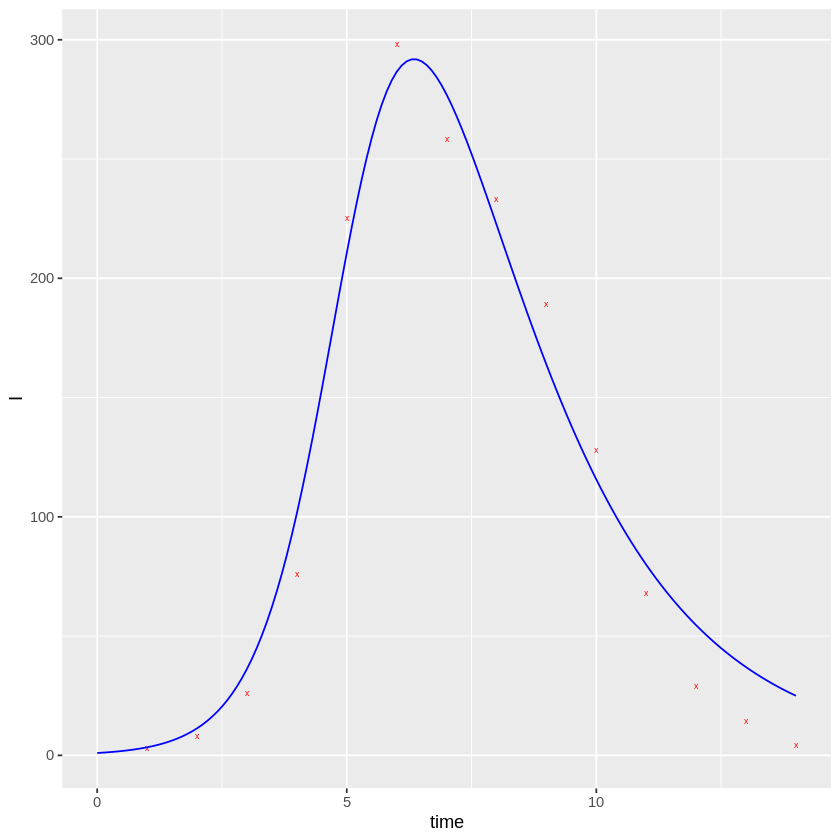

In [6]:
#Set up
require(ggplot2)
opt_plot <- ggplot()

# Plot observed data
opt_plot <- opt_plot + geom_point(aes(x = time, y = I)
                                , colour = "red"
                                , shape  = "x" 
                                , data = flu_data)
# Add optimised model's output to our plot
opt_plot <- opt_plot + geom_line(aes(x = time, y = I)
                                 , colour = "blue"
                                 , data   = opt_mod)
opt_plot

Note your model's output fits the observed data quite well, but not perfectly.

In general, we will find that a model can rarely be made to fit given data perfectly, particularly where that data is noisy.